## TextGCN

**TextGCN**（Graph Convolutional Networks for Text Classification）是一种用于文本分类的图卷积网络。它的原理基于图结构，能够有效地处理文本数据。以下是关于TextGCN的详细信息：

1. **原理**：
   - **图构建**：首先，TextGCN基于文本语料库构建一个大型文本图。在这个图中，单词和文档作为节点，单词与文档之间的共现关系作为边。
   - **图卷积**：接下来，TextGCN使用图卷积网络（GCN）在构建的文本图上进行学习。GCN能够有效地分析丰富的关系结构并保留全局结构信息。
   - **节点表示学习**：TextGCN初始化单词和文档的节点表示为one-hot编码，然后联合学习单词和文档的嵌入，受文档的已知类别标签监督。

2. **特点**：
   - **全局信息利用**：TextGCN能够捕捉文本中的全局特征，不仅仅局限于局部连续词序列。
   - **高效性**：即使在少量训练数据的情况下，TextGCN也能表现出色，表现出对小数据集的鲁棒性。

3. **问题解决**：
   - TextGCN解决了传统文本分类方法中容易忽视全局词共现的问题。
   - 它还克服了一些先前方法在处理图结构时的局限性。

4. **提出年份**：
   - TextGCN最早由Yao et al.于2019年提出。

总之，TextGCN是一种强大的文本分类模型，通过图卷积网络有效地利用文本数据的全局结构信息，同时具有良好的鲁棒性。


在 **TextGCN**（Graph Convolutional Networks for Text Classification）中，图的边是如何构成的呢？

1. **数据构建**：
   - 首先，TextGCN基于文本语料库构建一个大型文本图。在这个图中，单词和文档作为节点，单词与文档之间的共现关系作为边。
   - 具体而言，有两种类型的边：
     - **文档-单词边**：表示文档中的单词共现。这些边的权重通常使用TF-IDF（词频-逆文档频率）来衡量。
     - **单词-单词边**：表示不同单词之间的共现关系。这些边的权重可以使用PMI（点互信息）来计算。

2. **文档-单词边**：
   - 这些边连接文档节点和单词节点。
   - 边的权重通常使用TF-IDF值，其中TF表示词在文档中的频率，IDF表示逆文档频率。

3. **单词-单词边**：
   - 这些边连接不同的单词节点。
   - 边的权重可以使用PMI值来衡量，其中PMI表示两个单词共现的概率相对于它们在文档中独立出现的概率。

总之，TextGCN中的图边是通过文档中单词的共现关系构建的，以便有效地捕获全局词共现信息。

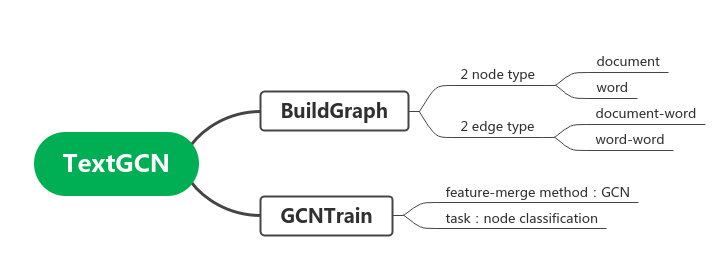

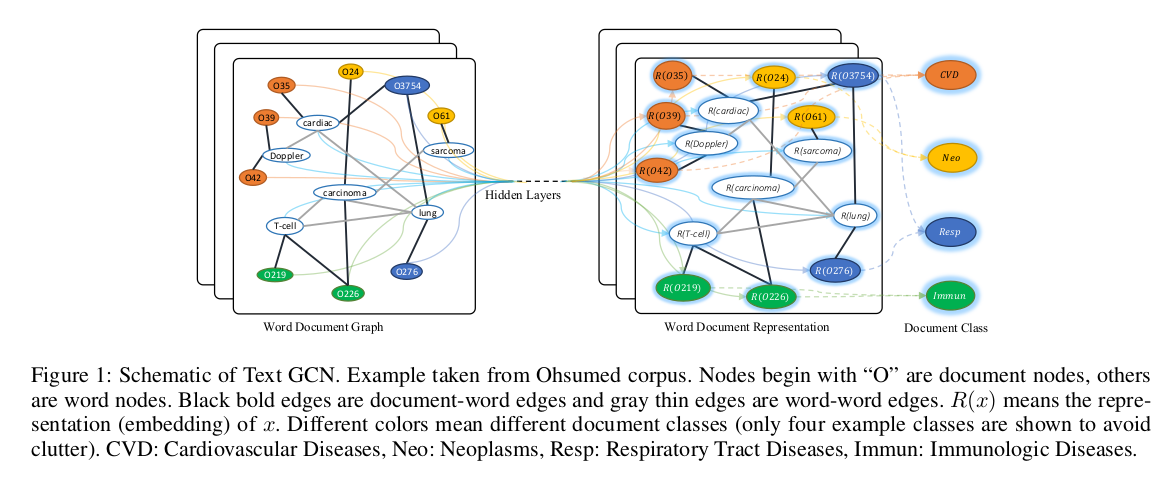

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

In [2]:
# 读取CSV文件
df = pd.read_csv('分词后data.csv')
df = df.dropna()
df.head()

,文本,标签
0,商业秘密 秘密性 维系 商业价值 垄断 地位 前提条件,0
1,南口 阿玛施 新春 第一批 限量 春装 店 春暖花开 淑女 裙冰 蓝色 公主 衫 气质 粉小...,1
2,带给 常州 一场 壮观 视觉 盛宴,0
3,原因 不明 泌尿系统 结石,0
4,年 盐城 拉回来 麻麻 嫁妆,0


In [3]:
from collections import Counter
data = df['文本'].tolist()
label = df['标签'].tolist()
print(len(data), len(label)) #查看语料信息
print(Counter(label)) #查看不同标签文本数量

1241 1241
Counter({0: 1119, 1: 122})


In [4]:
train_data, test_data = train_test_split(df, test_size=0.3, shuffle = True)
original_train_sentences = train_data["文本"]
original_labels_train = train_data["标签"]
original_test_sentences = test_data["文本"]
original_labels_test = test_data["标签"]
train_size = len(original_train_sentences)
test_size = len(original_test_sentences)
print('训练数据：', train_size, '测试数据：', test_size)

训练数据： 868 测试数据： 373


In [5]:
sentences = list(original_train_sentences) + list( original_test_sentences)
tokenize_sentences = [] #保持语料的词语列表
word_list_dict = {} #保持词典
for sentence in sentences:
    word_list_temp = sentence.split()
    for word in word_list_temp: 
        word_list_dict[word] = 1
    tokenize_sentences.append(word_list_temp)
word_list = list(word_list_dict.keys())
vocab_length = len(word_list)

In [6]:
print(tokenize_sentences[0])
print('词典大小', len(word_list_dict))

['标牌', '写', '手机', '天使', '电话号码']
词典大小 5918


In [7]:
word_id_map = {} #保存word to index 
for i in range(vocab_length):
    word_id_map[word_list[i]] = i   
print(word_id_map['红包'])
print(word_id_map['中国'])

1057
81


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #选择计算设备
device

device(type='cuda')

In [9]:
unique_labels=np.unique(original_labels_train)
num_class = len(unique_labels)
print('类别数为:', num_class)

labels = original_labels_train.tolist()+original_labels_test.tolist()
labels = torch.LongTensor(labels).to(device)
print(len(labels))

类别数为: 2
1241


In [10]:
from math import log
row = []
col = []
weight = []

## 参数设置

In [11]:
EDGE = 2 # 边的种类 0:d2w 1:d2w+w2w 2:d2w+w2w+d2d
NODE = 0 # 0:one-hot #1:BERT 
NUM_LAYERS = 2 

HIDDEN_DIM = 200
DROP_OUT = 0.1
LR = 3e-5
WEIGHT_DECAY = 0
EARLY_STOPPING = 10
NUM_EPOCHS = 200

## word-word边: PMI

在自然语言处理领域，**点互信息**（Pointwise Mutual Information，PMI）是一种用于衡量两个词语之间关联性的统计指标。它在文本挖掘、信息检索、词向量模型等任务中被广泛应用。让我详细解释一下：

1. **定义与计算**：
   - PMI衡量了两个事件之间的相关性，即它们共同出现的概率相对于它们独立出现的概率。
   - 具体而言，对于两个随机事件A和B，PMI的计算公式如下：
     $ \text{PMI}(A, B) = \log \left( \frac{p(A, B)}{p(A) \cdot p(B)} \right)$
     其中：
     - $p(A, B)$：事件A和B同时发生的概率。
     - $p(A)$和$p(B)$：事件A和B分别独立发生的概率。

2. **用途**：
   - 在自然语言处理中，PMI常用于词语之间的关联度计算。例如，可以使用PMI来发现文本中的相关词对，如“苹果”和“手机”。
   - PMI还用于构建词向量模型，例如Word2Vec。

3. **举例说明**：
   - 假设我们有一个文本语料库，我们想计算单词“like”的极性（正向情感或负向情感）。我们先选择一些正向情感词，比如“good”。
   - 然后，我们计算“like”和“good”的PMI：
     $ \text{PMI}(\text{like}, \text{good}) = \log \left( \frac{p(\text{like}, \text{good})}{p(\text{like}) \cdot p(\text{good})} \right) $
   - 其中，$p(\text{like}, \text{good})$表示“like”和“good”在同一句话中出现的概率，$p(\text{like})$表示“like”的出现概率，$p(\text{good})$表示“good”的出现概率。
   - 如果PMI越大，表示“like”的正向情感倾向越明显。

总之，PMI是一种有用的指标，用于衡量词语之间的相关性，特别在自然语言处理中具有重要作用。

In [12]:
if EDGE >= 1:
    window_size = 20
    total_W = 0
    word_occurrence = {}
    word_pair_occurrence = {}

    def ordered_word_pair(a, b):
        if a > b:
            return b, a
        else:
            return a, b

    def update_word_and_word_pair_occurrence(q):
        unique_q = list(set(q))
        for i in unique_q:
            try:
                word_occurrence[i] += 1
            except:
                word_occurrence[i] = 1
        for i in range(len(unique_q)):
            for j in range(i+1, len(unique_q)):
                word1 = unique_q[i]
                word2 = unique_q[j]
                word1, word2 = ordered_word_pair(word1, word2)
                try:
                    word_pair_occurrence[(word1, word2)] += 1
                except:
                    word_pair_occurrence[(word1, word2)] = 1


    for ind in tqdm(range(train_size+test_size)):
        words = tokenize_sentences[ind]

        q = []
        # push the first (window_size) words into a queue
        for i in range(min(window_size, len(words))):
            q += [word_id_map[words[i]]]
        # update the total number of the sliding windows
        total_W += 1
        # update the number of sliding windows that contain each word and word pair
        update_word_and_word_pair_occurrence(q)

        now_next_word_index = window_size
        # pop the first word out and let the next word in, keep doing this until the end of the document
        while now_next_word_index<len(words):
            q.pop(0)
            q += [word_id_map[words[now_next_word_index]]]
            now_next_word_index += 1
            # update the total number of the sliding windows
            total_W += 1
            # update the number of sliding windows that contain each word and word pair
            update_word_and_word_pair_occurrence(q)

    for word_pair in word_pair_occurrence:
        i = word_pair[0]
        j = word_pair[1]
        count = word_pair_occurrence[word_pair]
        word_freq_i = word_occurrence[i]
        word_freq_j = word_occurrence[j]
        pmi = log((count * total_W) / (word_freq_i * word_freq_j))
        if pmi <=0:
            continue
        row.append(train_size + i)
        col.append(train_size + j)
        weight.append(pmi)
        row.append(train_size + j)
        col.append(train_size + i)
        weight.append(pmi)

  0%|          | 0/1241 [00:00<?, ?it/s]

In [13]:
print(len(row), len(col))
print(len(weight))

98970 98970
98970


In [14]:
print(weight[0:10])

[6.70502691241052, 6.70502691241052, 3.56953269648137, 3.56953269648137, 3.9324381901707386, 3.9324381901707386, 7.398174092970465, 7.398174092970465, 2.8763855159214247, 2.8763855159214247]


## doc-word边: Tf-idf

In [15]:
#get each word appears in which document
word_doc_list = {}
for word in word_list:
    word_doc_list[word]=[]

for i in range(len(tokenize_sentences)):
    doc_words = tokenize_sentences[i]
    unique_words = set(doc_words)
    for word in unique_words:
        exsit_list = word_doc_list[word]
        exsit_list.append(i)
        word_doc_list[word] = exsit_list

#document frequency
word_doc_freq = {}
for word, doc_list in word_doc_list.items():
    word_doc_freq[word] = len(doc_list)

# term frequency
doc_word_freq = {}

for doc_id in range(len(tokenize_sentences)):
    words = tokenize_sentences[doc_id]
    for word in words:
        word_id = word_id_map[word]
        doc_word_str = str(doc_id) + ',' + str(word_id)
        if doc_word_str in doc_word_freq:
            doc_word_freq[doc_word_str] += 1
        else:
            doc_word_freq[doc_word_str] = 1

In [16]:
for i in range(len(tokenize_sentences)):
    words = tokenize_sentences[i]
    doc_word_set = set()
    for word in words:
        if word in doc_word_set:
            continue
        j = word_id_map[word]
        key = str(i) + ',' + str(j)
        freq = doc_word_freq[key]
        if i < train_size:
            row.append(i)
        else:
            row.append(i + vocab_length)
        col.append(train_size + j)
        idf = log(1.0 * len(tokenize_sentences) / word_doc_freq[word_list[j]])
        weight.append(freq * idf)
        doc_word_set.add(word)

In [17]:
print(len(row), len(col))
print(len(weight))

108971 108971
108971


## doc-doc边: jaccard


在自然语言处理领域，**Jaccard系数**（也称为Jaccard相似性系数）是一种用于衡量样本集之间相似性和多样性的统计指标。它在文本挖掘、信息检索、词向量模型等任务中被广泛应用。

以下是关于Jaccard系数的详细解释：

1. **定义与计算**：
   - Jaccard系数衡量了两个样本集的相似性，即它们共同出现的元素数量相对于它们总共出现的元素数量。
   - 具体而言，对于两个集合A和B，Jaccard系数的计算公式如下：
     $ \text{Jaccard系数}(A, B) = \frac{|A \cap B|}{|A \cup B|} $
     其中：
     - $|A \cap B|$：集合A和B的交集的大小。
     - $|A \cup B|$：集合A和B的并集的大小。

2. **用途**：
   - Jaccard系数常用于文本相似性计算、聚类、去重等任务。
   - 在文本挖掘中，它可以用于发现相似的文档、词语、标签等。
   - 在信息检索中，Jaccard系数可以衡量查询和文档之间的相似性。
   - 在词向量模型中，Jaccard系数可以用于评估词汇相似性。

3. **举例说明**：
   - 假设我们有两个文本集合：
     - A：{"apple", "banana", "orange"}
     - B：{"banana", "grape", "kiwi"}
   - 那么它们的Jaccard系数为：
     $ \text{Jaccard系数}(A, B) = \frac{|\{"banana"\}|}{|\{"apple", "banana", "orange", "grape", "kiwi"\}|} = \frac{1}{5} = 0.2 $
   - 这表示集合A和B之间的相似性较低。

总之，Jaccard系数是一种用于衡量样本集相似性的有用指标，在自然语言处理中具有广泛的应用。

In [18]:
import nltk

if EDGE>=2:
    tokenize_sentences_set = [set(s) for s in tokenize_sentences]
    jaccard_threshold = 0.2
    for i in tqdm(range(len(tokenize_sentences))):
        for j in range(i+1, len(tokenize_sentences)):
            jaccard_w = 1 - nltk.jaccard_distance(tokenize_sentences_set[i], tokenize_sentences_set[j])
            if jaccard_w > jaccard_threshold:
                if i < train_size:
                    row.append(i)
                else:
                    row.append(i + vocab_length)
                if j < train_size:
                    col.append(j)
                else:
                    col.append(vocab_length + j)
                weight.append(jaccard_w)
                if j < train_size:
                    row.append(j)
                else:
                    row.append(j + vocab_length)
                if i < train_size:
                    col.append(i)
                else:
                    col.append(vocab_length + i)
                weight.append(jaccard_w)

  0%|          | 0/1241 [00:00<?, ?it/s]

In [19]:
print(len(row), len(col))
print('边的个数：', len(weight))

109121 109121
边的个数： 109121


## 邻接矩阵 Adjacent matrix

In [20]:
import scipy.sparse as sp
node_size = train_size + vocab_length + test_size
print('结点个数:', node_size)
adj = sp.csr_matrix((weight, (row, col)), shape=(node_size, node_size))

# build symmetric adjacency matrix
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

结点个数: 7159


In [21]:
def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo(), d_inv_sqrt
    
adj, norm_item = normalize_adj(adj + sp.eye(adj.shape[0]))


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape).to(device)

adj = sparse_mx_to_torch_sparse_tensor(adj)

## 节点特征初始化

In [22]:
NODE = 0 # 0:one-hot #1:BERT 
if NODE == 0: #默认为随机初始化
    features = np.arange(node_size)
    features = torch.FloatTensor(features).to(device)
else: #用BERT词向量进行初始化
    
    from flair.embeddings import TransformerDocumentEmbeddings, TransformerWordEmbeddings
    from flair.data import Sentence
    doc_embedding = TransformerDocumentEmbeddings('bert-base-uncased', fine_tune=False)
    word_embedding = TransformerWordEmbeddings('bert-base-uncased', layers='-1',subtoken_pooling="mean")

    sent_embs = []
    word_embs = {}

    for ind in tqdm(range(train_size+test_size)):
        sent = tokenize_sentences[ind]
        sentence = Sentence(" ".join(sent[:512]),use_tokenizer=False)
        doc_embedding.embed(sentence)
        sent_embs.append(sentence.get_embedding().tolist())
        words = Sentence(" ".join(sent[:512]),use_tokenizer=False)
        word_embedding.embed(words)
        for token in words:
            word = token.text
            embedding = token.embedding.tolist()
            if word not in word_embs:
                word_embs[word] = embedding
            else:
                word_embs[word] = np.minimum(word_embs[word], embedding)

    word_embs_list = []
    for word in word_list:
        word_embs_list.append(word_embs[word])

    features = sent_embs[:train_size] + word_embs_list + sent_embs[train_size:]

    import scipy.sparse as sp
    def preprocess_features(features):
        """Row-normalize feature matrix and convert to tuple representation"""
        rowsum = np.array(features.sum(1))
        r_inv = np.power(rowsum, -1).flatten()
        r_inv[np.isinf(r_inv)] = 0.
        r_mat_inv = sp.diags(r_inv)
        features = r_mat_inv.dot(features)
        return features

    features = preprocess_features(sp.csr_matrix(features)).todense()
    features = torch.FloatTensor(features).to(device)

In [23]:
NUM_LAYERS = 2 
HIDDEN_DIM = 200
DROP_OUT = 0.5
LR =0.02
# LR = 3e-5
WEIGHT_DECAY = 0
EARLY_STOPPING = 20
NUM_EPOCHS = 200

## GCN层

In [24]:
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module


class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features,  drop_out = 0, activation=None, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.zeros(1, out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters(in_features, out_features)
        self.dropout = torch.nn.Dropout(drop_out)
        self.activation =  activation

    def reset_parameters(self,in_features, out_features):
        stdv = np.sqrt(6.0/(in_features+out_features))
        # stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        # if self.bias is not None:
        #     torch.nn.init.zeros_(self.bias)
            # self.bias.data.uniform_(-stdv, stdv)


    def forward(self, input, adj, feature_less = False):
        if feature_less:
            support = self.weight
            support = self.dropout(support)
        else:
            input = self.dropout(input)
            support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            output = output + self.bias
        if self.activation is not None:
            output = self.activation(output)
        return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

## TextGCN模型

In [25]:
import torch.nn as nn
import torch.nn.functional as F

class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, n_layers = 2):
        super(GCN, self).__init__()
        self.n_layers = n_layers
        self.gc_list = []
        if n_layers >= 2:
            self.gc1 = GraphConvolution(nfeat, nhid, dropout, activation = nn.ReLU())
            self.gc_list = nn.ModuleList([GraphConvolution(nhid, nhid, dropout, activation = nn.ReLU()) for _ in range(self.n_layers-2)])
            self.gcf = GraphConvolution(nhid, nclass, dropout)
        else:
            self.gc1 = GraphConvolution(nfeat, nclass, dropout)

    def forward(self, x, adj):
        if self.n_layers>=2:
            x = self.gc1(x, adj, feature_less = True)
            for i in range(self.n_layers-2):
                x = self.gc_list[i](x,adj)
            x = self.gcf(x,adj)
        else:
            x = self.gc1(x, adj, feature_less = True)
        return x

In [26]:
def cal_accuracy(predictions,labels):
    pred = torch.argmax(predictions,-1).cpu().tolist()
    lab = labels.cpu().tolist()
    cor = 0
    for i in range(len(pred)):
        if pred[i] == lab[i]:
            cor += 1
    return cor/len(pred)

## 训练

## 初始化模型

In [27]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
model = GCN(nfeat=node_size, nhid=HIDDEN_DIM, nclass=num_class, dropout=DROP_OUT,n_layers=NUM_LAYERS).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [35]:
print(model)
total_params = 0
for name, parameters in model.named_parameters():
    if not parameters.requires_grad: continue
    print(name, ':', parameters.size())
    total_params += parameters.numel()
print("模型需要训练参数为：", total_params)

GCN(
  (gc1): GraphConvolution (7159 -> 200)
  (gc_list): ModuleList()
  (gcf): GraphConvolution (200 -> 2)
)
gc1.weight : torch.Size([7159, 200])
gc1.bias : torch.Size([1, 200])
gcf.weight : torch.Size([200, 2])
gcf.bias : torch.Size([1, 2])
模型需要训练参数为： 1432402


In [28]:
def generate_train_val(train_pro=0.9): #训练集中90%用于训练，10%为验证集
    real_train_size = int(train_pro*train_size)
    val_size = train_size-real_train_size

    idx_train = np.random.choice(train_size, real_train_size,replace=False)
    idx_train.sort()
    idx_val = []
    pointer = 0
    for v in range(train_size):
        if pointer<len(idx_train) and idx_train[pointer] == v:
            pointer +=1
        else:
            idx_val.append(v)
    idx_test = range(train_size+vocab_length, node_size)
    return idx_train, idx_val, idx_test

idx_train, idx_val, idx_test = generate_train_val()

In [29]:
print(len(idx_train), len(idx_val), len(idx_test))
print(idx_val)#验证集文档编号

781 87 373
[18, 23, 26, 40, 46, 68, 69, 86, 94, 105, 109, 135, 157, 163, 179, 193, 195, 203, 217, 218, 224, 235, 237, 238, 246, 247, 282, 287, 296, 313, 326, 328, 330, 345, 351, 353, 358, 373, 408, 417, 423, 424, 435, 461, 468, 474, 479, 480, 488, 490, 509, 511, 518, 525, 566, 567, 572, 587, 593, 597, 608, 620, 622, 626, 639, 645, 647, 651, 652, 656, 662, 667, 671, 674, 691, 695, 698, 701, 725, 751, 774, 806, 817, 831, 841, 842, 851]


## 模型训练

In [30]:
import time

def train_model(show_result = True):
    val_loss = []
    for epoch in range(NUM_EPOCHS):
        t = time.time()
        model.train()
        optimizer.zero_grad()
        output= model(features, adj)
        loss_train = criterion(output[idx_train], labels[idx_train])
        acc_train = cal_accuracy(output[idx_train], labels[idx_train])
        loss_train.backward()
        optimizer.step()

        model.eval()
        output = model(features, adj)

        loss_val = criterion(output[idx_val], labels[idx_val])
        val_loss.append(loss_val.item())
        acc_val = cal_accuracy(output[idx_val], labels[idx_val])
        if show_result:
            if epoch % 5 == 0: 
                print(  'Epoch: {:04d}'.format(epoch+1),
                        'loss_train: {:.4f}'.format(loss_train.item()),
                        'acc_train: {:.4f}'.format(acc_train),
                        'loss_val: {:.4f}'.format(loss_val.item()),
                        'acc_val: {:.4f}'.format(acc_val),
                        'time: {:.4f}s'.format(time.time() - t))

        if epoch > EARLY_STOPPING and np.min(val_loss[-EARLY_STOPPING:]) > np.min(val_loss[:-EARLY_STOPPING]) :
            if show_result:
                print("Early Stopping...")
            break

train_model()

Epoch: 0001 loss_train: 0.6966 acc_train: 0.1754 loss_val: 0.5762 acc_val: 0.9195 time: 14.9255s
Epoch: 0006 loss_train: 0.2211 acc_train: 0.9052 loss_val: 0.2566 acc_val: 0.9195 time: 0.0199s
Epoch: 0011 loss_train: 0.1496 acc_train: 0.9052 loss_val: 0.1985 acc_val: 0.9195 time: 0.0199s
Epoch: 0016 loss_train: 0.1039 acc_train: 0.9052 loss_val: 0.1647 acc_val: 0.9195 time: 0.0189s
Epoch: 0021 loss_train: 0.0942 acc_train: 0.9078 loss_val: 0.1775 acc_val: 0.9195 time: 0.0179s
Epoch: 0026 loss_train: 0.0673 acc_train: 0.9808 loss_val: 0.1766 acc_val: 0.9425 time: 0.0190s
Epoch: 0031 loss_train: 0.0267 acc_train: 0.9987 loss_val: 0.1997 acc_val: 0.8966 time: 0.0189s
Early Stopping...


In [31]:
from sklearn.metrics import classification_report

model.eval()
output = model(features, adj)
predictions = torch.argmax(output[idx_test],-1).cpu().tolist()
#输出结果报告
print(classification_report(original_labels_test.values, predictions, digits=4, target_names = ['正常短信', '垃圾短信']))

              precision    recall  f1-score   support

        正常短信     0.9865    0.8795    0.9299       332
        垃圾短信     0.4805    0.9024    0.6271        41

    accuracy                         0.8820       373
   macro avg     0.7335    0.8910    0.7785       373
weighted avg     0.9309    0.8820    0.8967       373



In [32]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(original_labels_test.values, predictions))

[[292  40]
 [  4  37]]
